# Distributions

We look at neuron activation distributions

## Get Activations
We first import dependancies and run the model to get some neuron distributions

In [2]:
try: # if in google colab, download necessary python files
  import google.colab 
  ! pip install -qq separability
except ModuleNotFoundError:
  pass

In [3]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from separability import Model
from separability.activations import get_midlayer_activations

In [4]:
opt = Model('facebook/opt-1.3b', limit=1000)
dataset = 'pile'

- Loaded facebook/opt-1.3b
 - Registered 24 OPT Attention Layers


In [ ]:
data = get_midlayer_activations( opt, dataset, 1e4, collect_ff=True, collect_attn=True )

ff_activations   = data["raw"]["ff"].permute( (1,2,0) )
attn_activations = data["raw"]["attn"].permute( (1,2,3,0) ).reshape( (opt.n_layers, opt.d_model, -1) )
print( ff_activations.size() )
print( attn_activations.size() )

## Plot Distributions for Neurons
We can investigate the distribution of some random neurons in the network.

In [6]:
def plot_activation_indices(activations, indices):
    for j in range(0, opt.n_layers, 7):
        plt.title(f"layer {j}")
        for i in indices:
            counts, bins = np.histogram( activations[j][i].cpu().numpy(), bins=100 )
            mids = (bins[:-1] + bins[1:]) / 2
            plt.semilogy( mids, counts )
        plt.show()

In [ ]:
plot_activation_indices( ff_activations, [0, 10, 100, 200, 300, 400, 500 ] )

In [ ]:

plot_activation_indices( attn_activations, [0, 10, 100, 200, 300, 400, 500 ] )

In [9]:
attn_means = torch.mean( attn_activations, dim=-1)
attn_indices = torch.sort( attn_means, dim=-1 ).indices.cpu().numpy()
indices = set([])
for i in range(opt.n_layers):
    indices.add( attn_indices[i][-1] )
    indices.add( attn_indices[i][-2] )
indices = np.sort( np.array(list(indices)) )
n_items = len(indices)

In [10]:
for j in range(opt.n_layers):
    break
    for i in indices:
        rgb = mpl.colors.hsv_to_rgb( (1, 1, i/n_items) )
        print( rgb )
        counts, bins = np.histogram( ff_activations[j][i].cpu().numpy(), bins=50 )
        mids = (bins[:-1] + bins[1:]) / 2
        plt.semilogy( mids, counts, label=f" dim {i}", color = rgb )
    plt.legend()
    plt.show()

In [11]:
pile_data = data
code_data = get_midlayer_activations( opt, "code", 1e4, collect_ff=True, collect_attn=True )

10403it [00:09, 1060.80it/s]                            


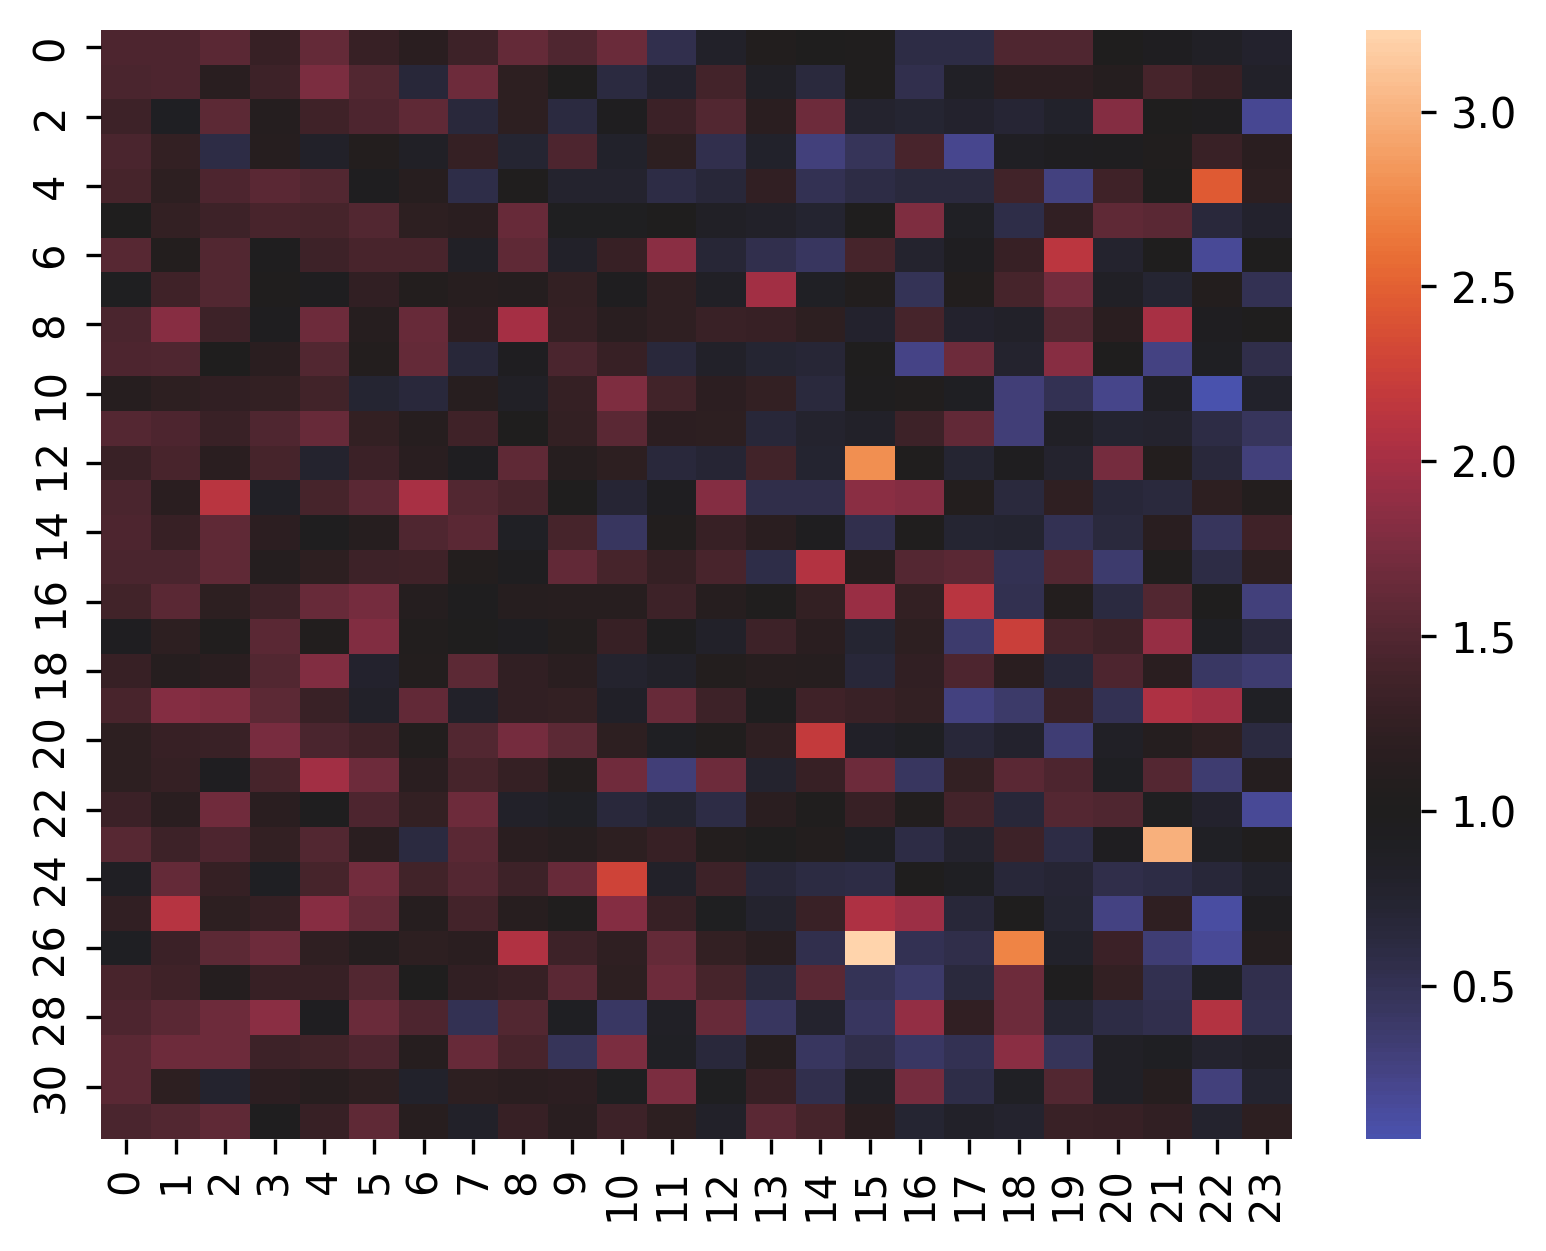

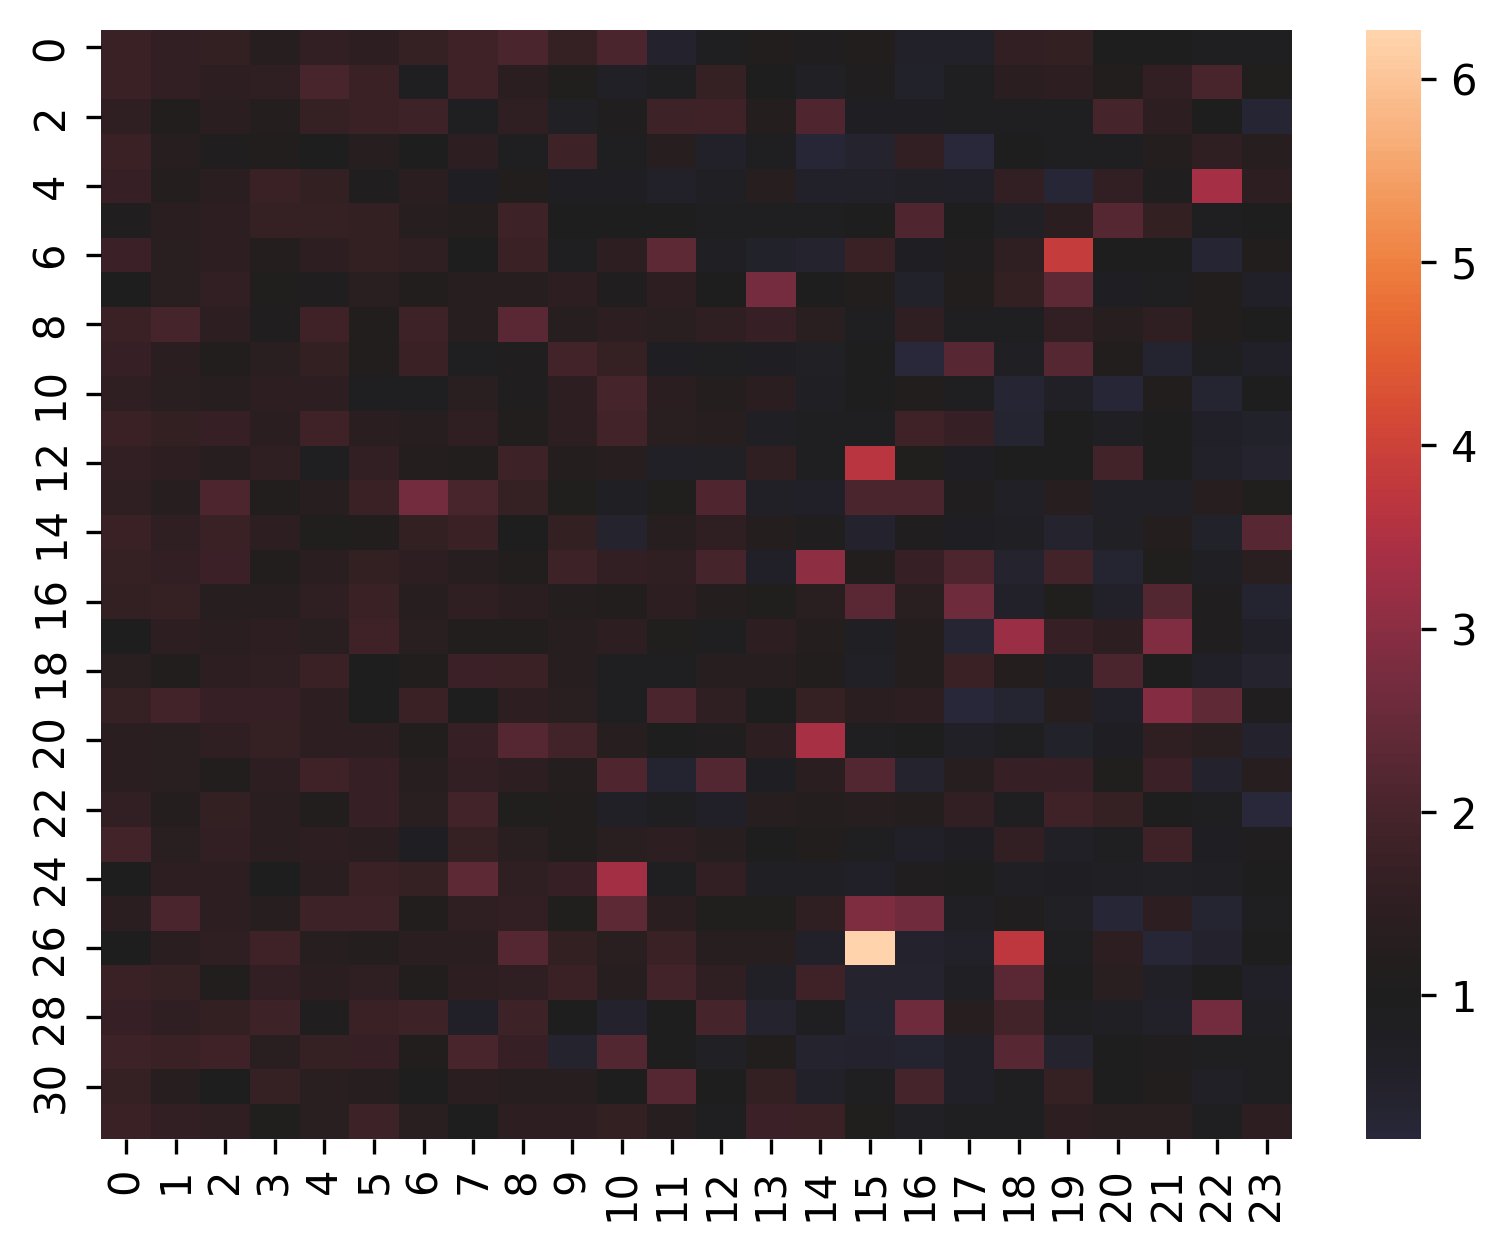

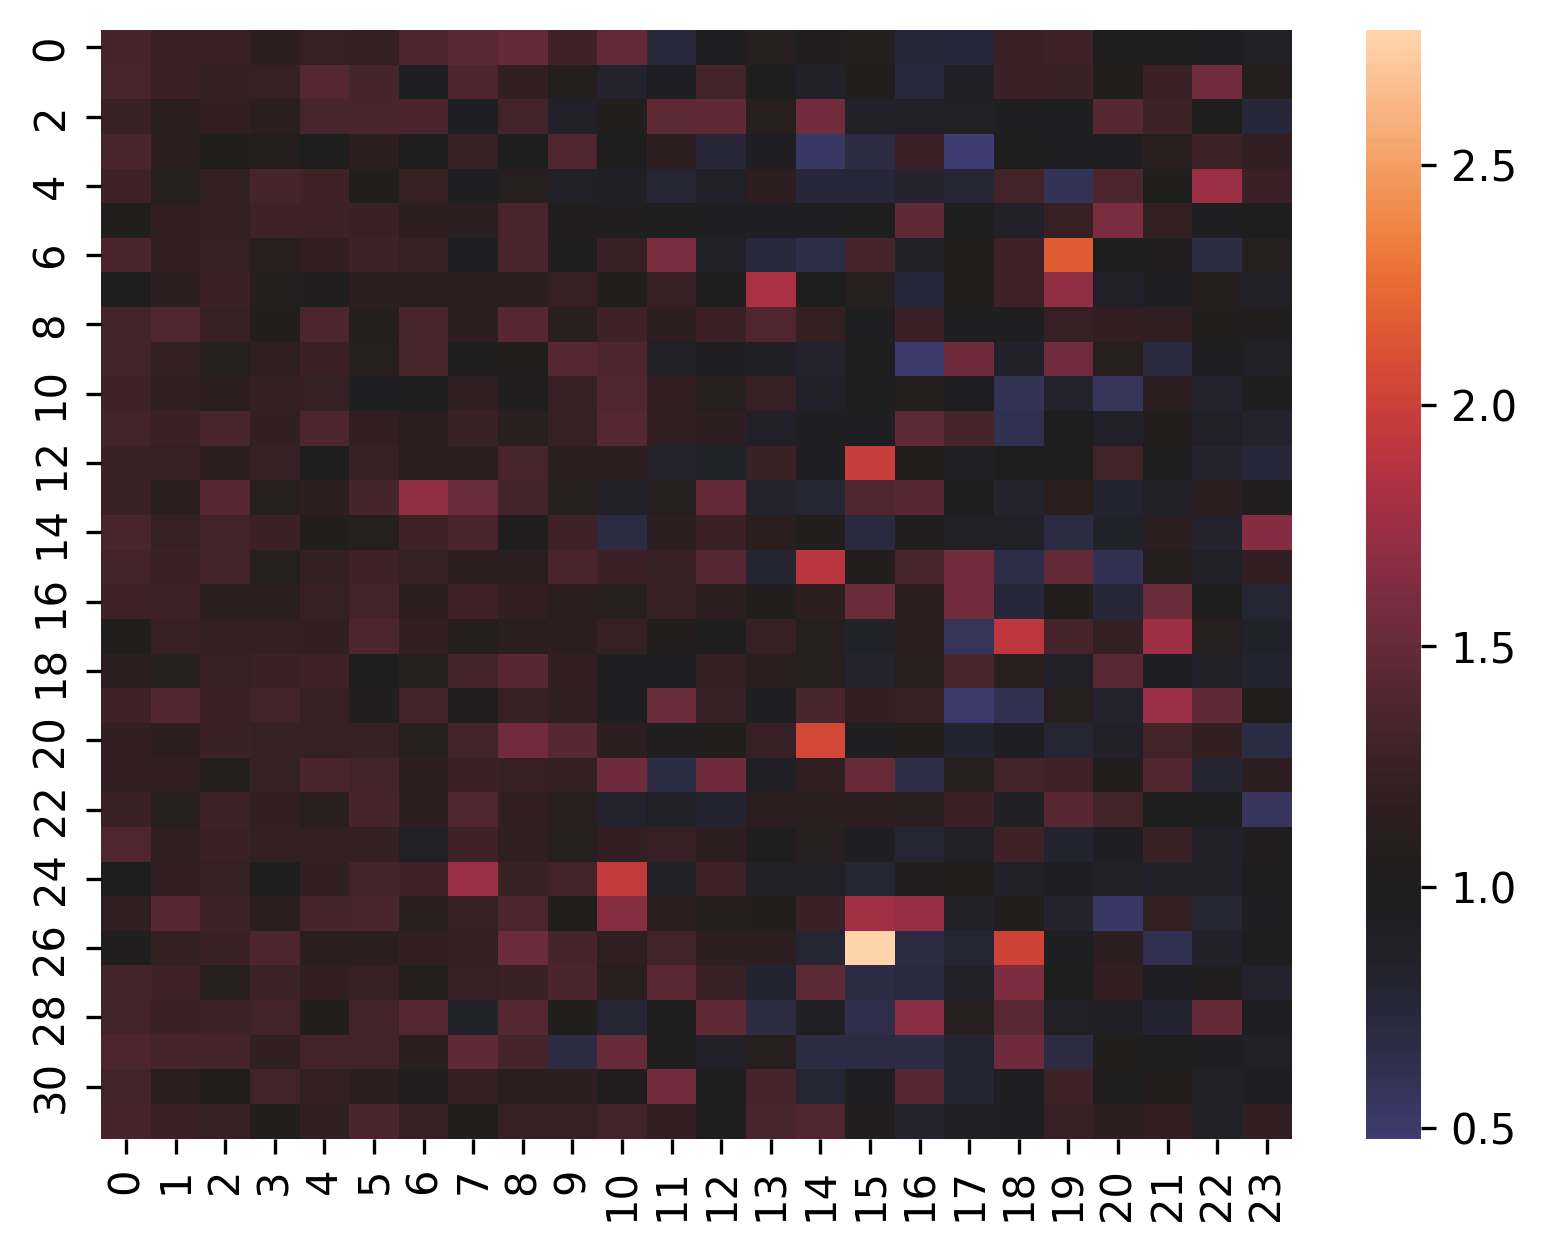

In [16]:
import seaborn as sns

metric1 = lambda x: x.std(dim=0)
metric2 = lambda x: x.abs().mean(dim=0)
metric3 = lambda x: x.abs().sqrt().mean(dim=0)
def ratio( cripple, focus, metric ):
    top    = metric( cripple["raw"]["attn"] )
    bottom = metric( focus["raw"]["attn"] ) + 1e-6
    return top / bottom

for metric in [metric1, metric2, metric3]:
    std_ratios = ratio( code_data, pile_data, metric )
    # std_ratio_means = std_ratios.mean(dim=-1)
    std_ratio_medians = torch.quantile(
        std_ratios.to(dtype=torch.float32), q=0.5, dim=-1)

    plt.figure()
    sns.heatmap(std_ratio_medians.T, center=1)

In [17]:
pile_attn = pile_data["raw"]["attn"].permute( (1,2,3,0) )
code_attn = code_data["raw"]["attn"].permute( (1,2,3,0) )

def plot_attn_head_neurons(i_layer, i_head, clamp=0.4):
    pile_head = pile_attn[i_layer, i_head].clamp(-clamp, clamp)
    code_head = code_attn[i_layer, i_head].clamp(-clamp, clamp)

    bins = lambda x: (x.bin_edges[1:] + x.bin_edges[:-1]) / 2
    normed_hist = lambda x: x.hist * ( 1e-6 * 1 /(x.bin_edges[1]-x.bin_edges[0]))

    fig, axes = plt.subplots(8, 1, figsize=(8,16))
    axes[0].set_title("Attention Head")
    for i in range(0, 8):
        ax = axes[i]
        pile_hist = pile_head[i].histogram(200)
        code_hist = code_head[i].histogram(200)
        ax.semilogy( bins(pile_hist), normed_hist(pile_hist), label="pile" )
        ax.semilogy( bins(code_hist), normed_hist(code_hist), label="code" )
    plt.legend()
    
    plt.show()

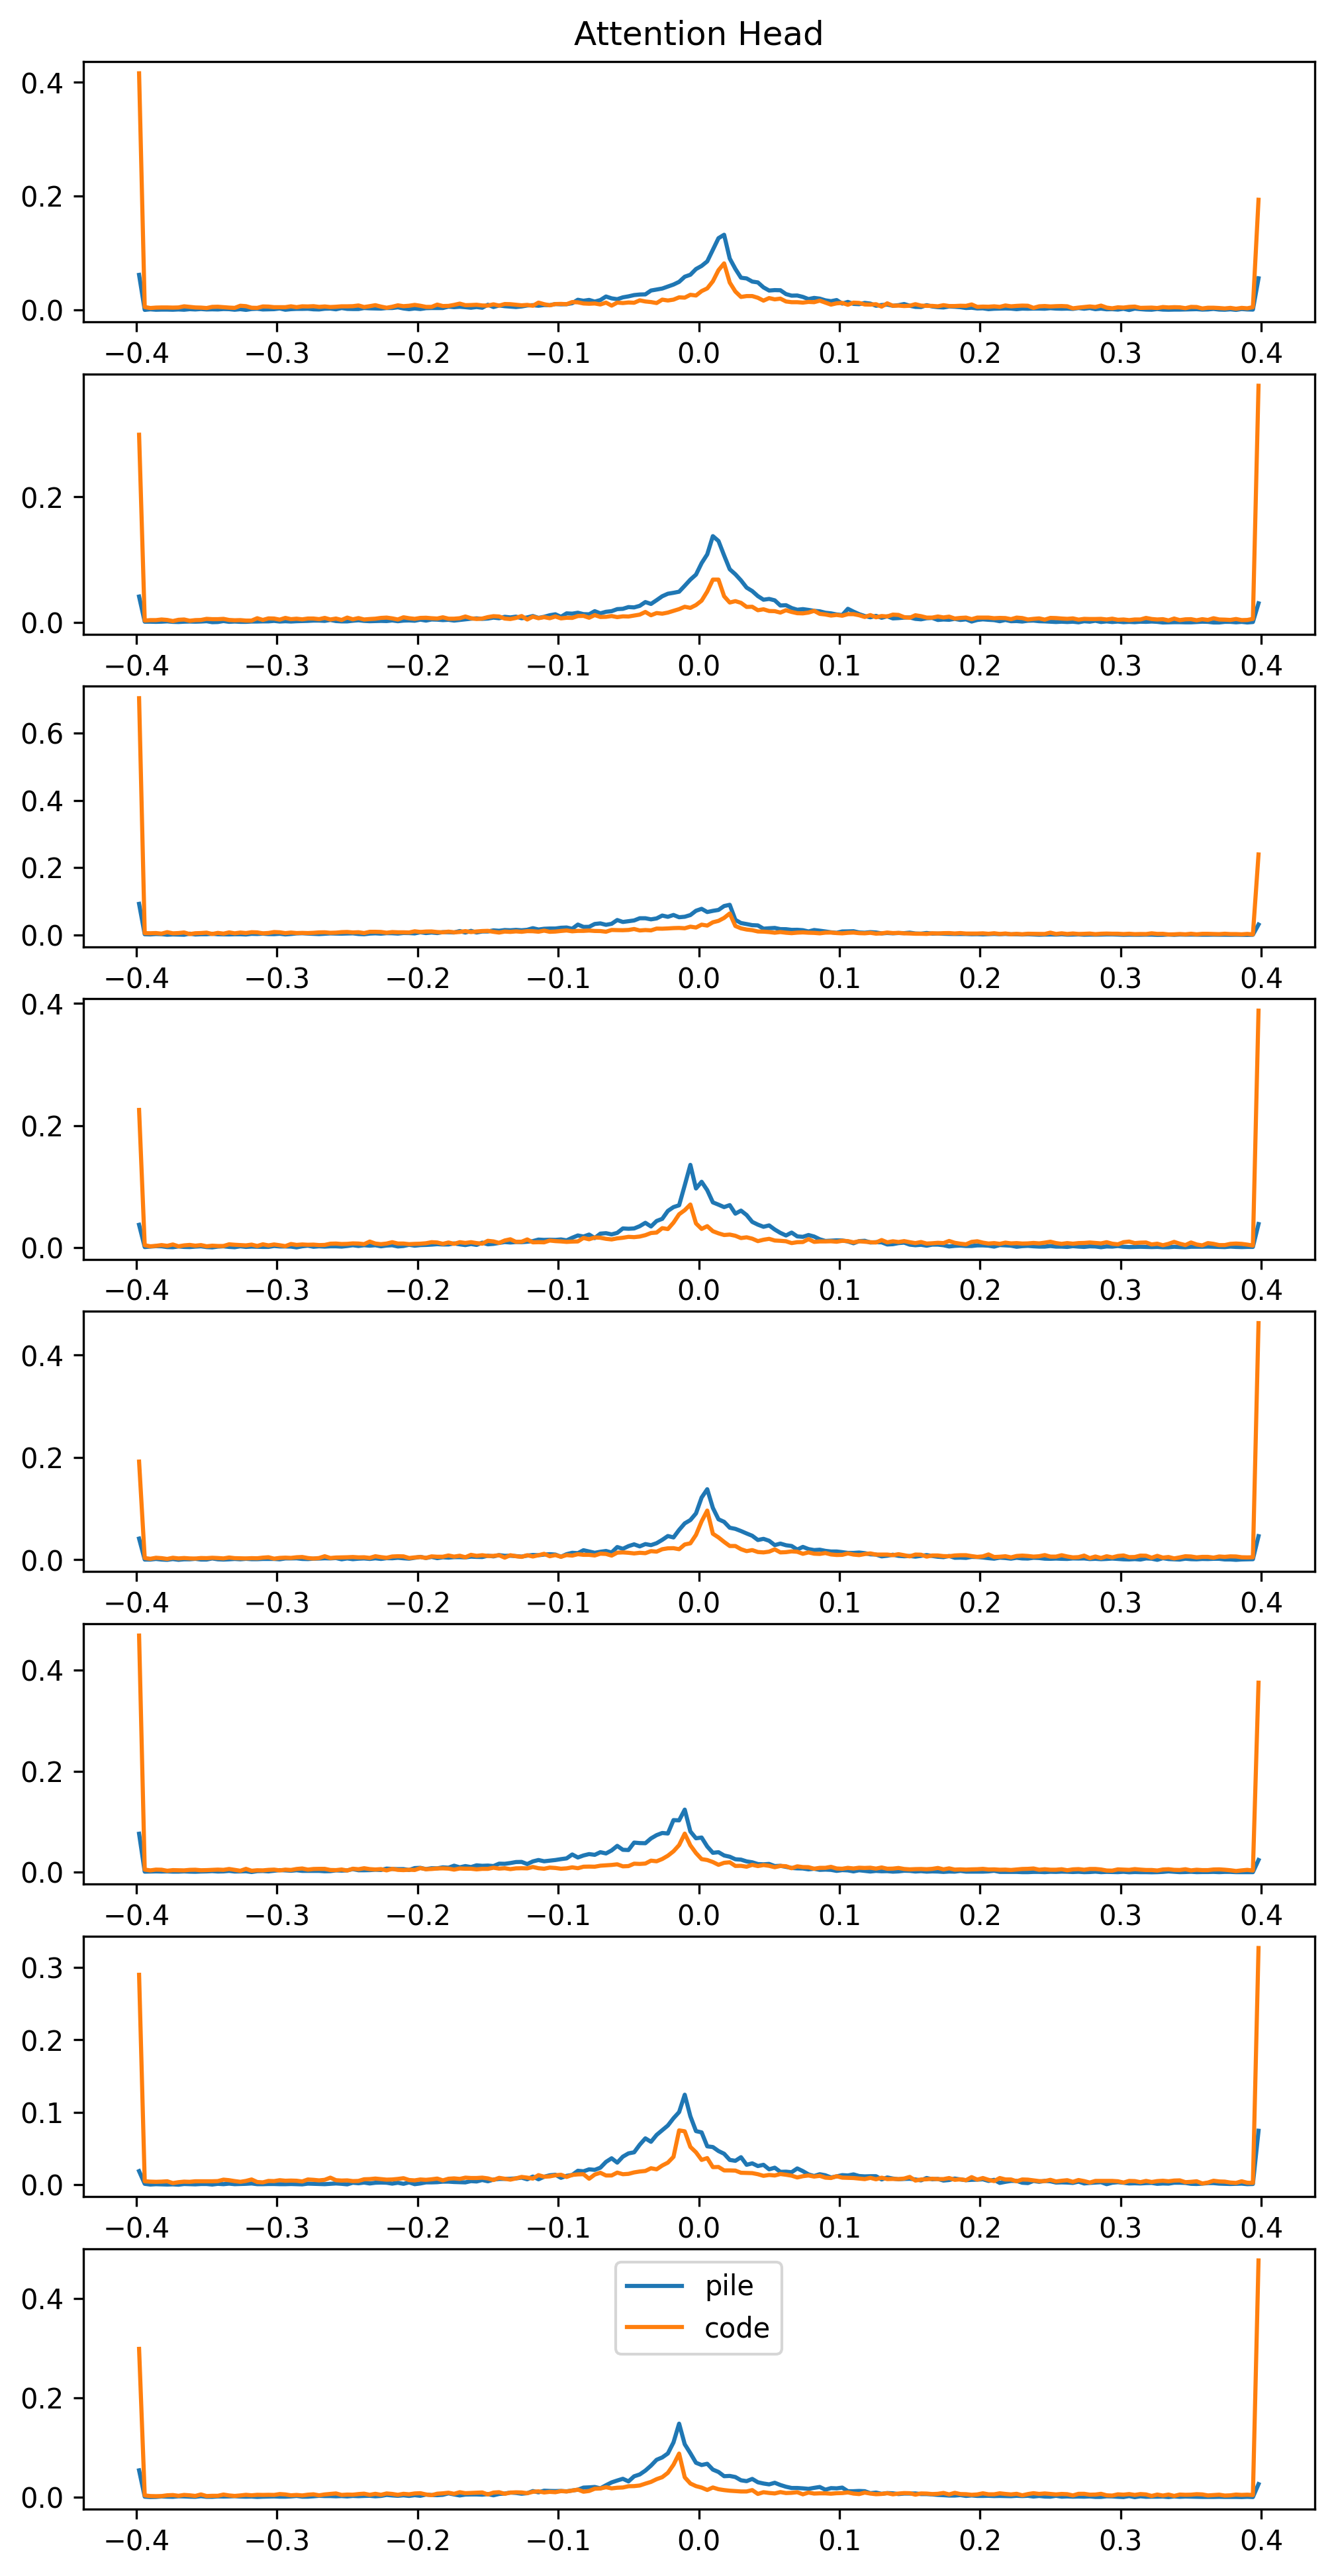

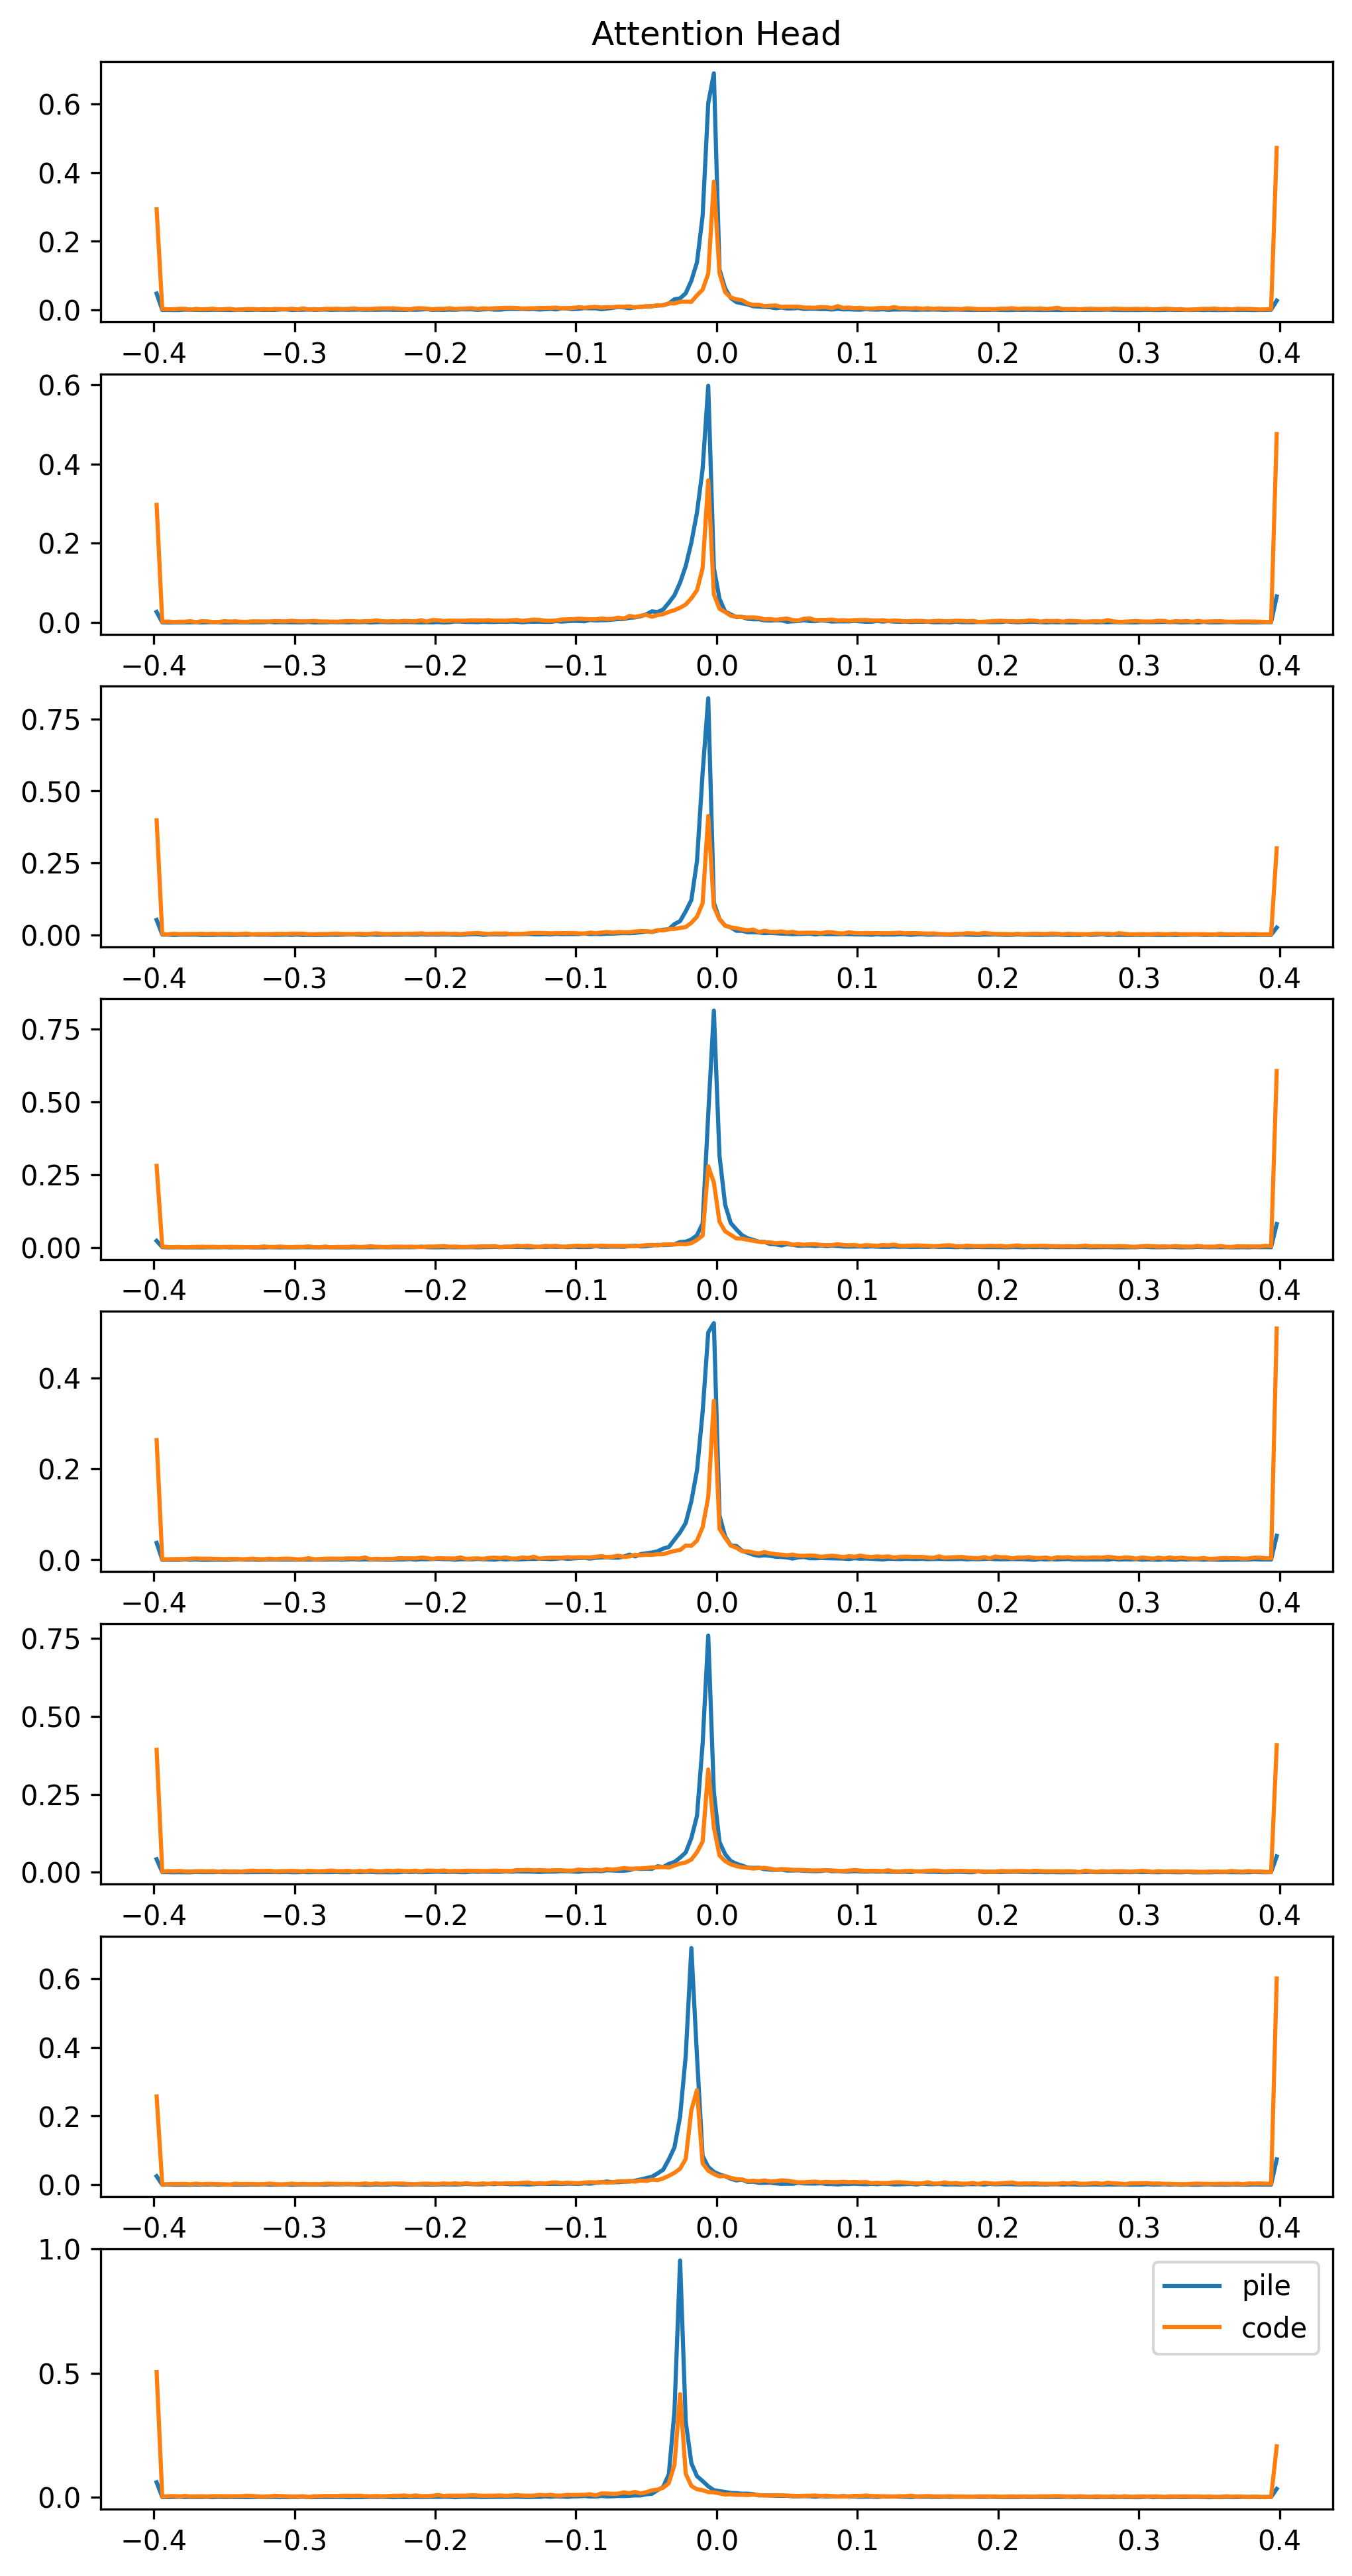

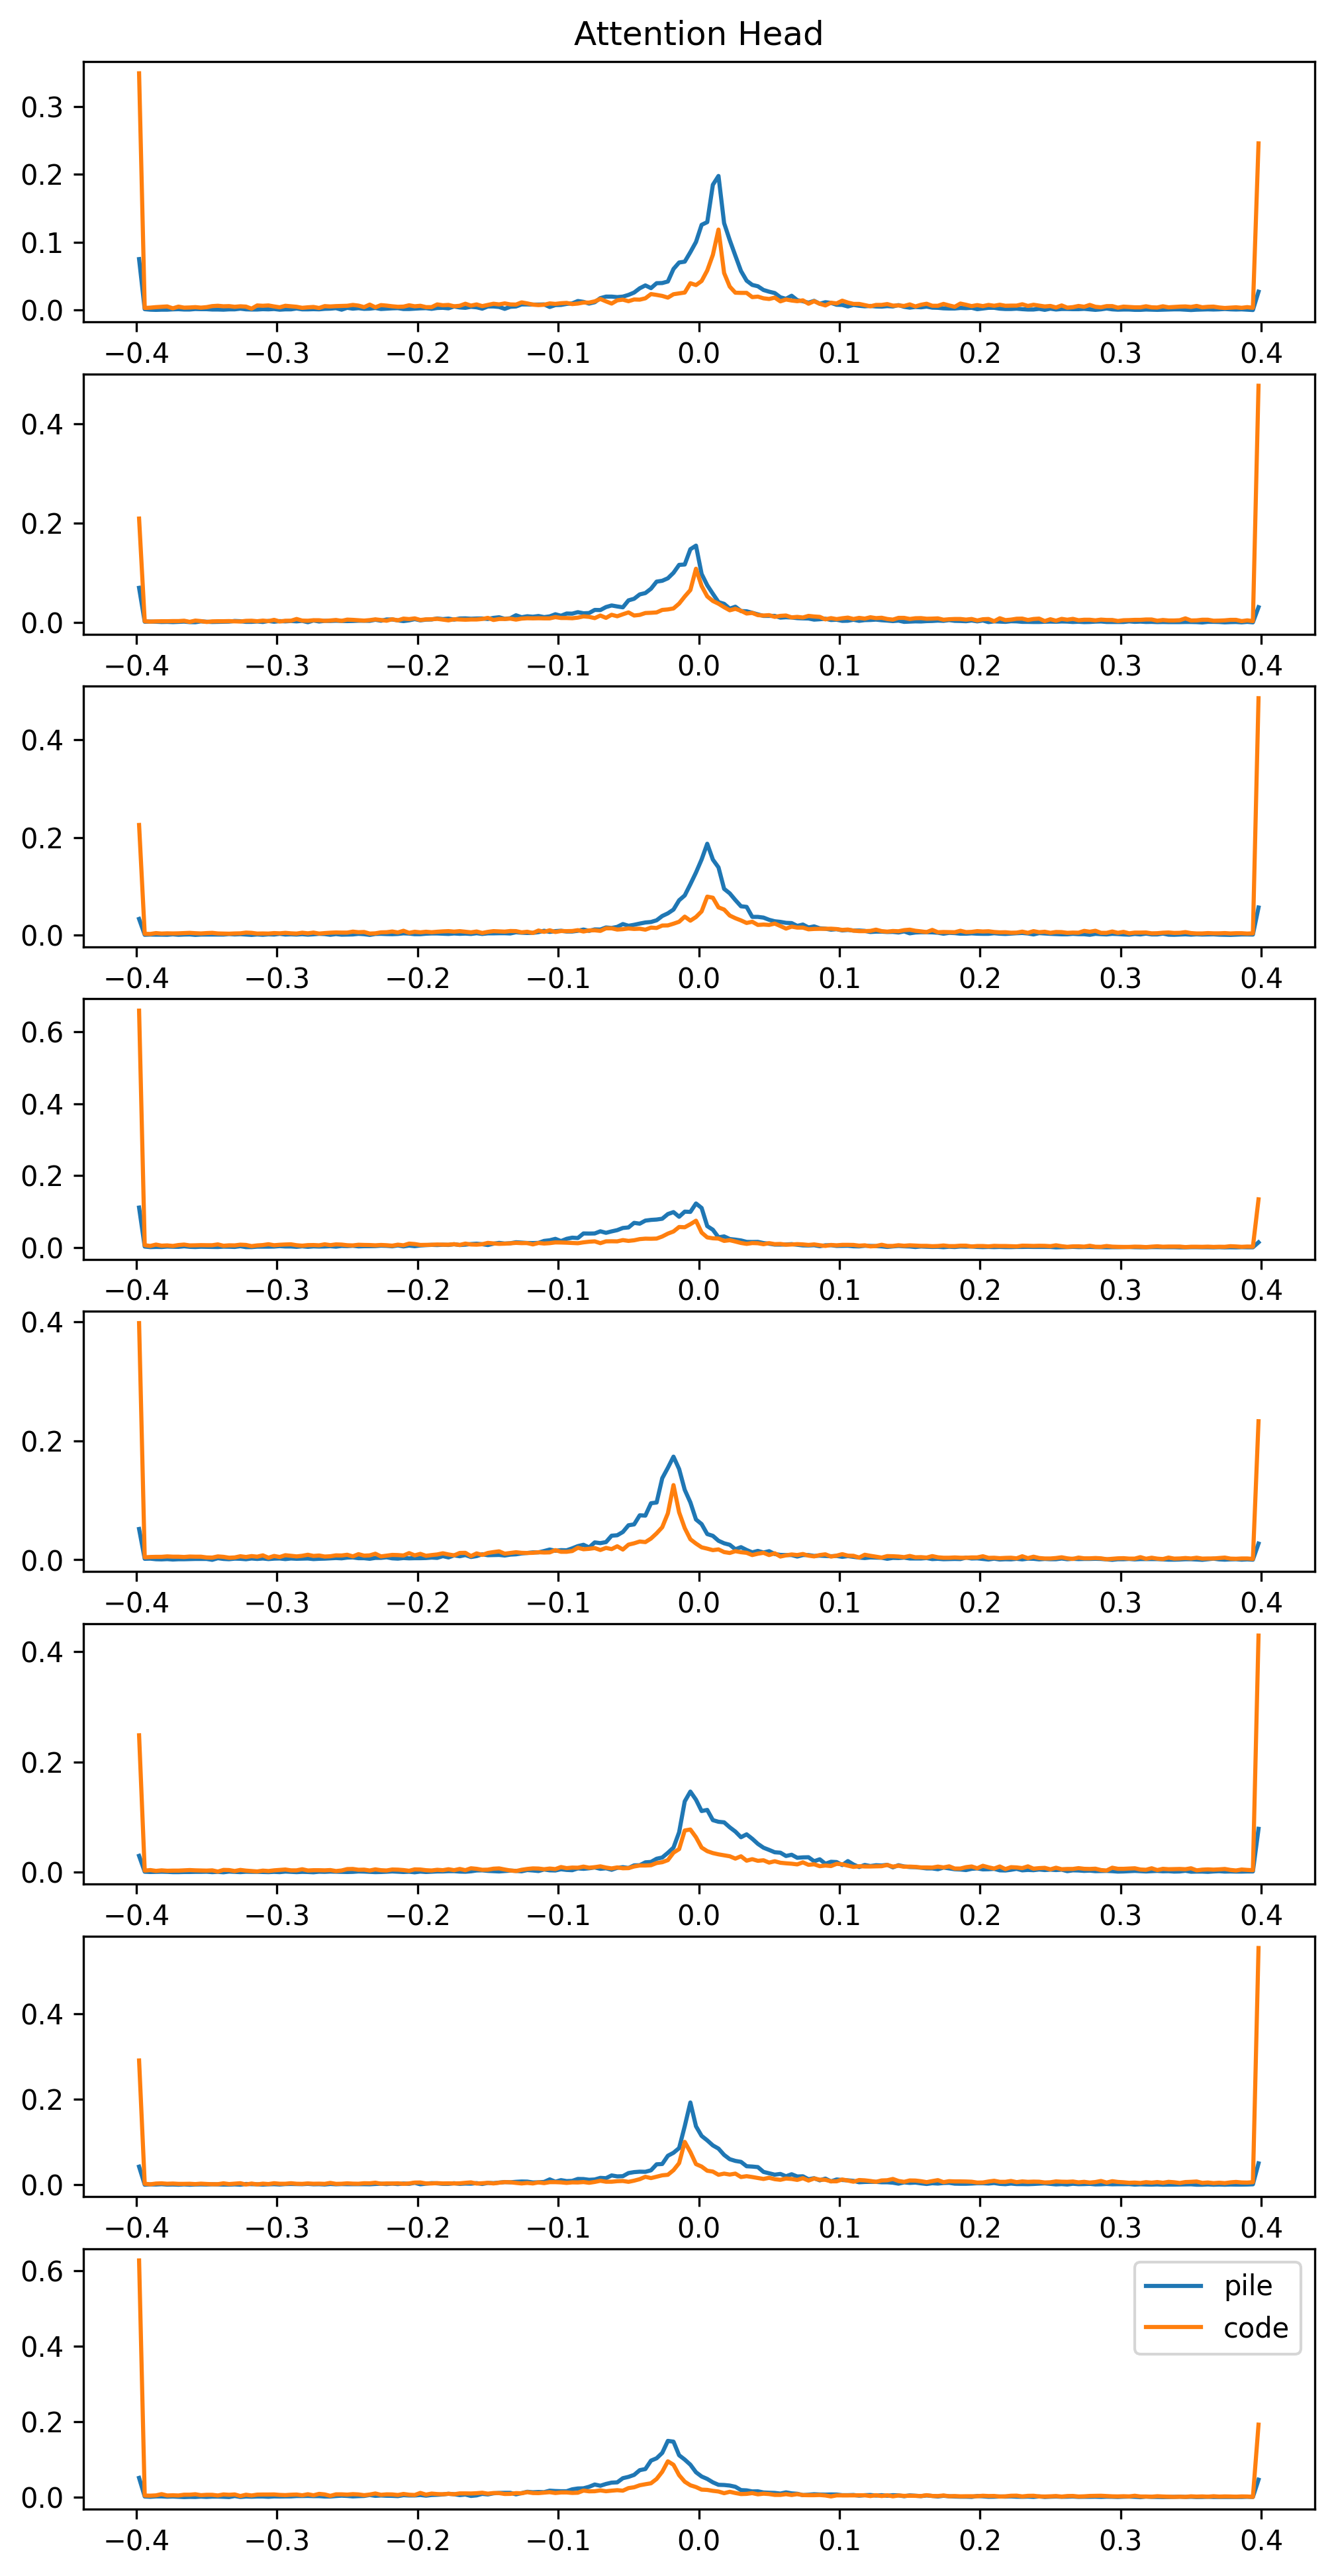

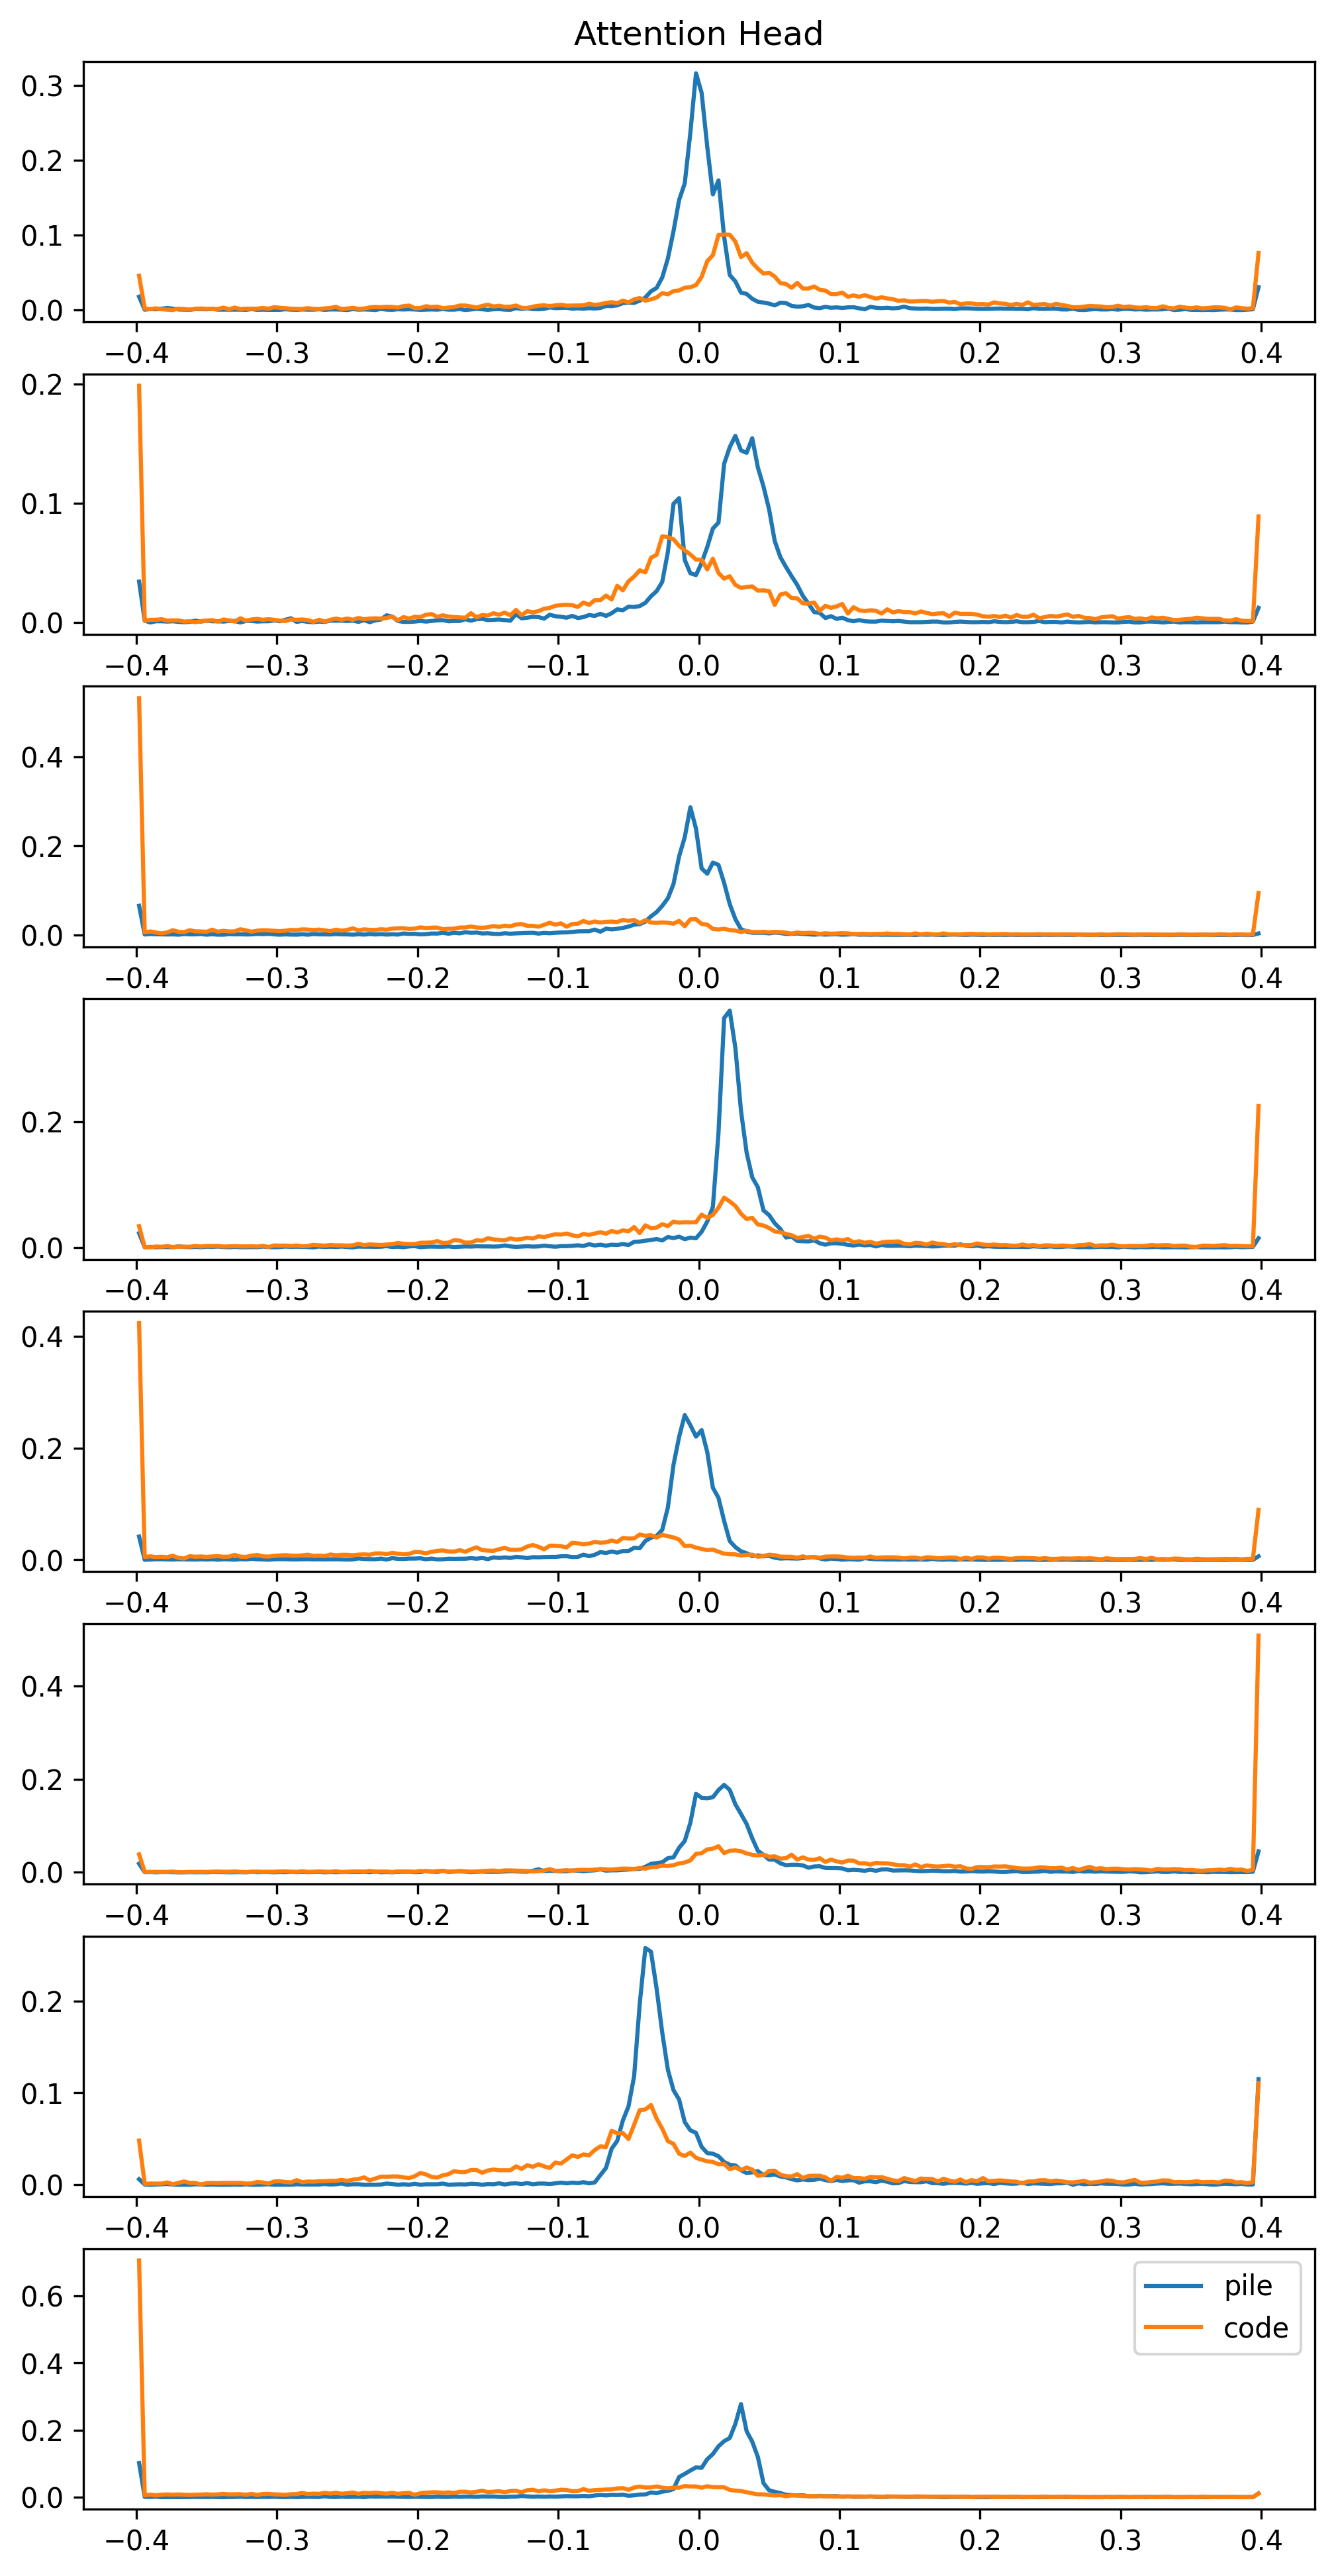

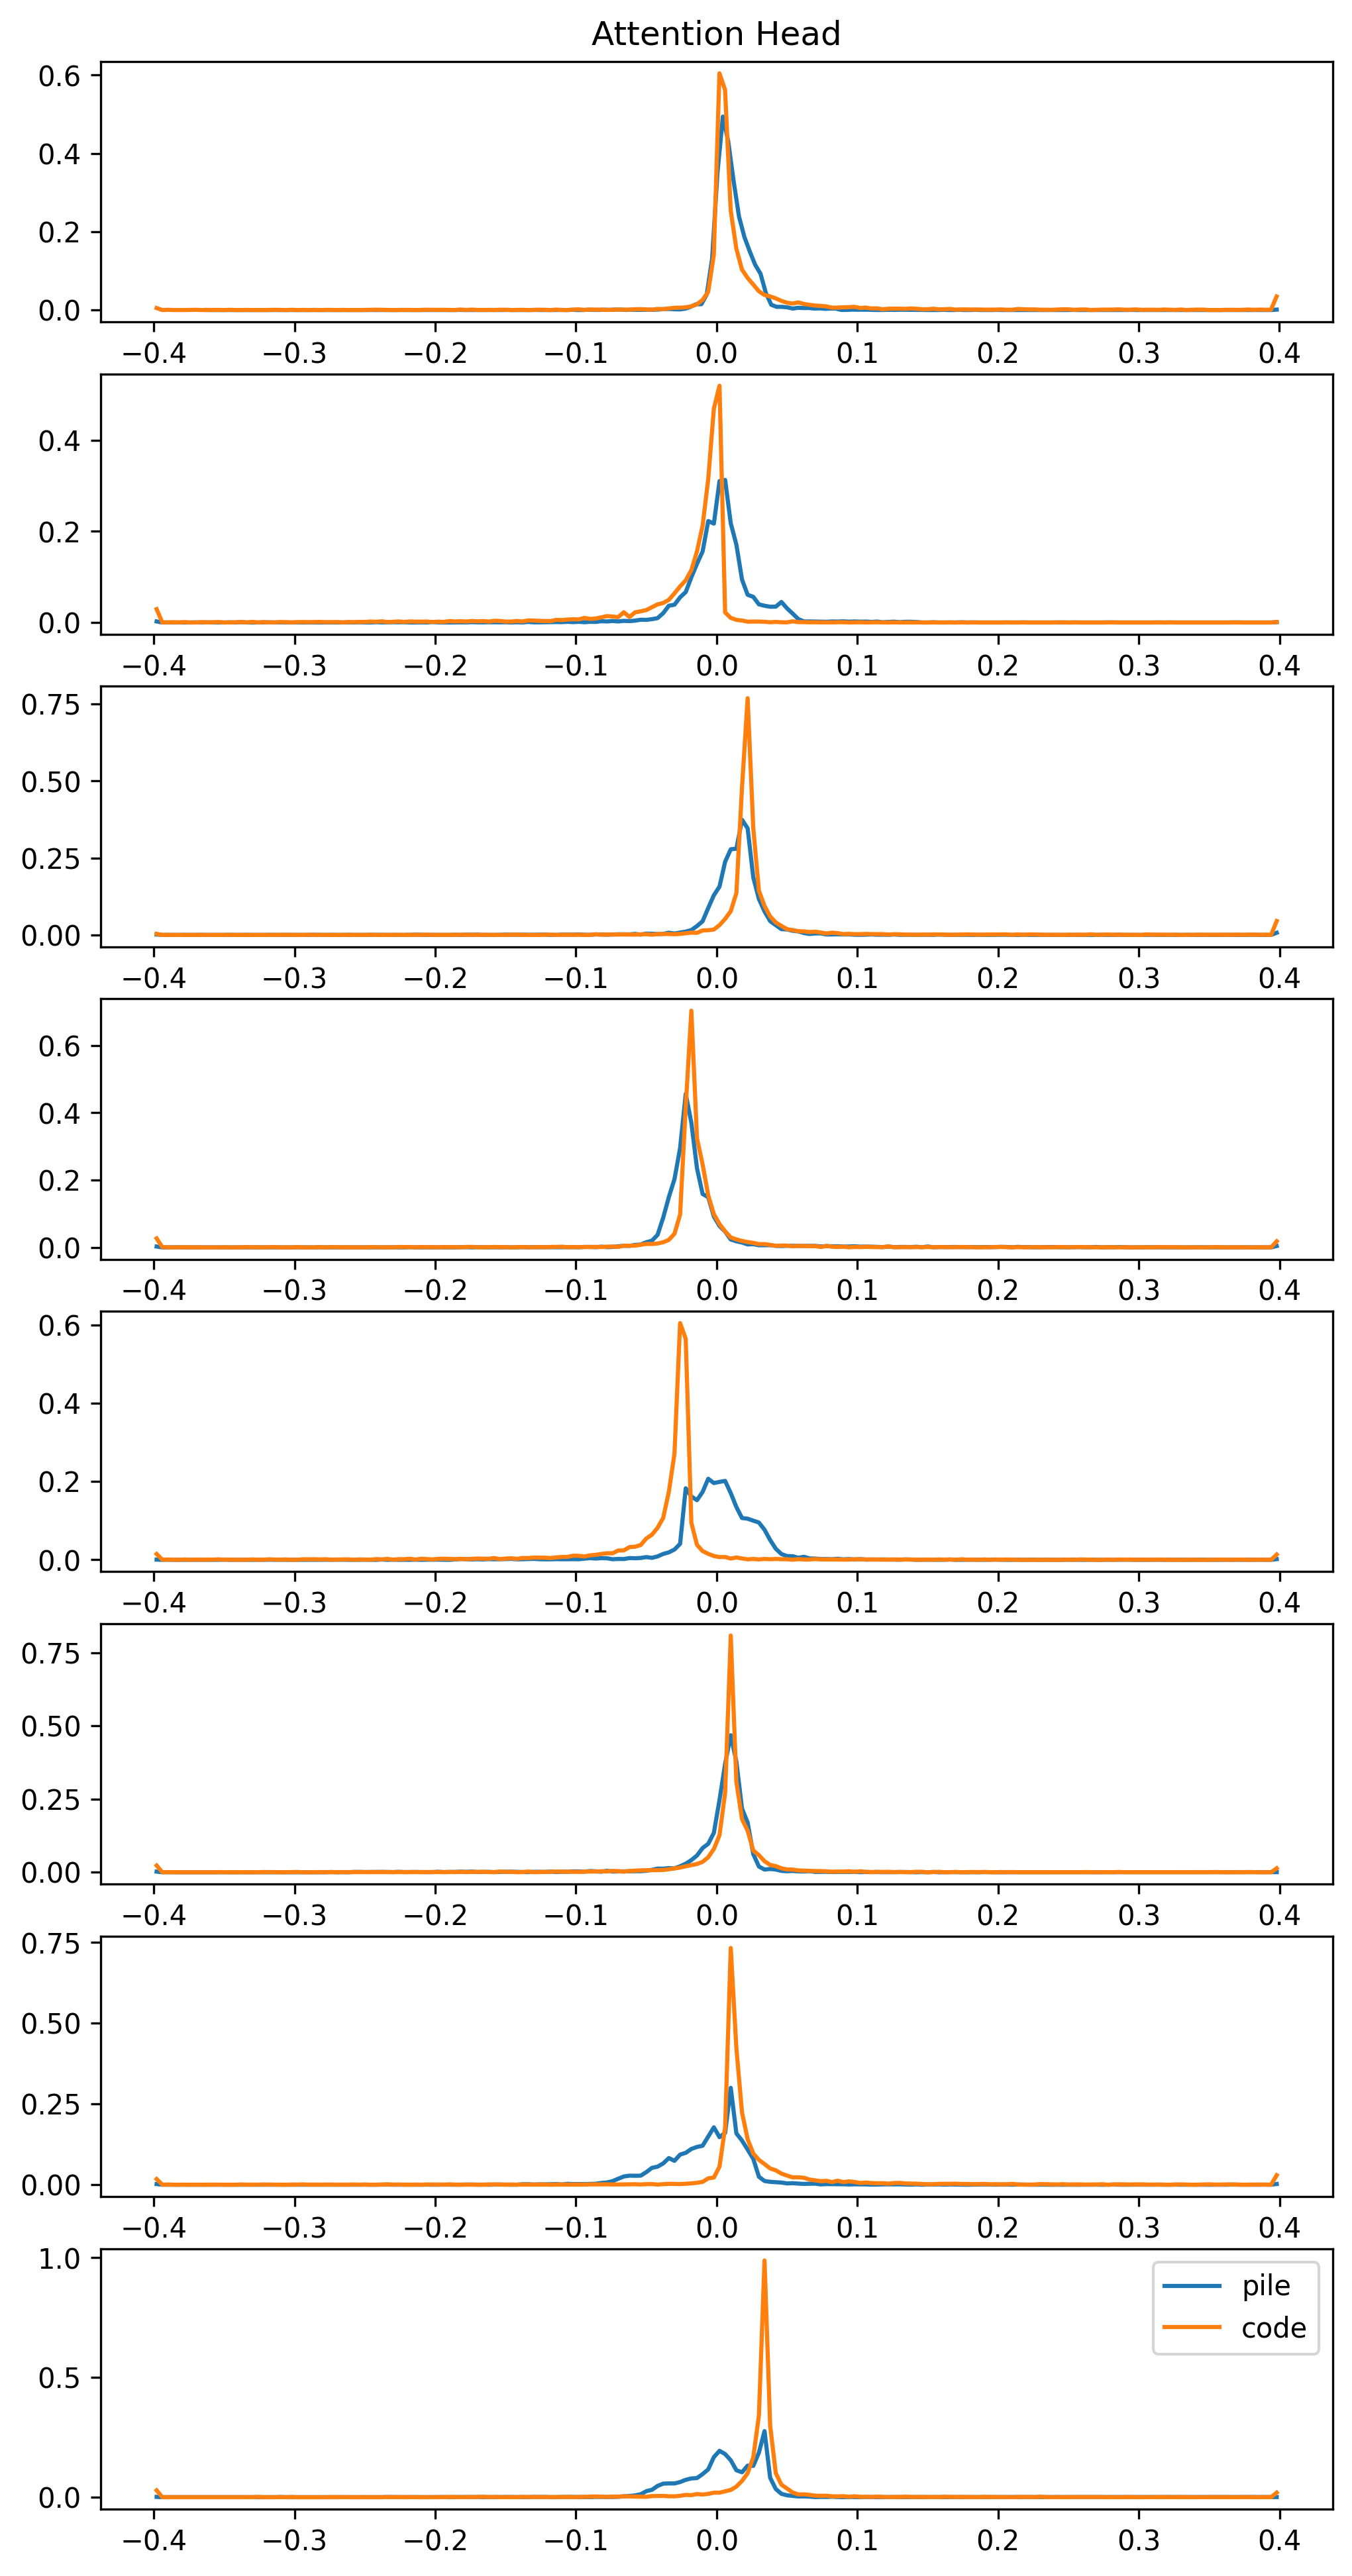

In [19]:
plot_attn_head_neurons(15, 12, 0.4)
plot_attn_head_neurons(15, 26, 0.4)
plot_attn_head_neurons(18, 26, 0.4)
plot_attn_head_neurons(19,  6, 0.4)
plot_attn_head_neurons(21, 23, 0.4)

#plot_attn_head_neurons(16,  9, 0.4)
#plot_attn_head_neurons(17,  3, 0.4)
#plot_attn_head_neurons(22, 10, 0.2)
#plot_attn_head_neurons(23, 22, 0.4)